In [ ]:
#| include: false
!nvidia-smi

Wed Jul  1 11:43:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#| include: false
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
#| include: false
!mkdir mobilenet_v2

If you see the way deep learning research has progressed over the years, it has always been guided by the need of the hour. If I were to develop a chronology out of it, it would be something like - train better model -\> train them faster -\> get them good at generalizing well, and so on. With a stern increase in the demand for using deep learning more as just another technology stack, there could not have been a better time to think about how do we make our models ***infer faster***. In this post, we are going to see how to use **TensorRT** to perform accelerated inference with TensorFlow (2) models. After all, making predictions with deep learning models is what makes you real 💰 and we would want to make sure that our bucks burned judiciously.

In [ ]:
mobilenet_v2 = tf.keras.applications.MobileNetV2(weights='imagenet')
mobilenet_v2.save('mobilenet_v2')

14540800/14536120 [==============================] - 0s 0us/step
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mobilenet_v2/assets


Here, `mobilenet_v2` is a directory and when you pass a directory to the save function, it serializes the model in the TensorFlow [<span class="underline">SavedModel</span>](https://www.tensorflow.org/guide/saved_model) format. This format makes it easier for us to be able to use it on different platforms - be it on GCP’s AI Platform, be it on TensorFlow JS, be it on TensorFlow Serving, and so on.

Now, there are some basic preprocessing steps to be followed before we can actually feed an image to this model -

In [ ]:
#| include: false
# Gather sample data
!wget -O elephant.jpg https://sm.mashable.com/t/mashable_sea/fun/i/indias-fir/indias-first-elephant-hospital-has-opened-and-people-are-rej_45f1.960.jpg

--2020-07-01 11:54:33--  https://sm.mashable.com/t/mashable_sea/fun/i/indias-fir/indias-first-elephant-hospital-has-opened-and-people-are-rej_45f1.960.jpg
Resolving sm.mashable.com (sm.mashable.com)... 23.76.82.130
Connecting to sm.mashable.com (sm.mashable.com)|23.76.82.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108273 (106K) [image/jpeg]
Saving to: ‘elephant.jpg’


elephant.jpg          0%[                    ]       0  --.-KB/s               
elephant.jpg        100%[===================>] 105.74K  --.-KB/s    in 0.009s  

2020-07-01 11:54:34 (11.5 MB/s) - ‘elephant.jpg’ saved [108273/108273]



In [ ]:
#| include: false
import time
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Prepare the image for prediction
img = tf.keras.preprocessing.image.load_img('elephant.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

Here’s how `elephant.jpg` looks like in case if anyone’s curious - 

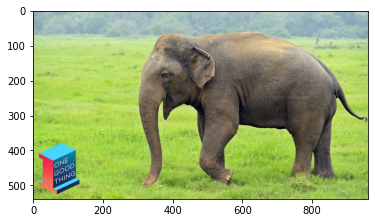

In [ ]:
#| echo: false
sample_image = plt.imread('elephant.jpg')
plt.imshow(sample_image)
plt.show()

Now, running the prediction and decoding it is just a matter of two lines of code - 

In [ ]:
# Run inference
preds = mobilenet_v2.predict(x)
print('Predicted:', tf.keras.applications.mobilenet_v2.decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504013', 'Indian_elephant', 0.70024925), ('n01871265', 'tusker', 0.2549572), ('n02504458', 'African_elephant', 0.0033761878)]


To find out how much time does this model take to predict a given image? Let’s write a short utility function to handle that - 

In [ ]:
def time_my_model(model, data):
    times = []
    for i in range(20):
        start_time = time.time()
        one_prediction = model.predict(data)
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

If we `run time_my_model` fives times the output would look like so - 

In [ ]:
#| echo: false
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)
time_my_model(mobilenet_v2, x)

average(sec):0.06,fps:15.48
average(sec):0.03,fps:32.26
average(sec):0.03,fps:32.48
average(sec):0.03,fps:31.14
average(sec):0.03,fps:31.67


Can we further optimize this? We will start the next section with this question. 

# Optimizing the pre-trained image classification model

Note that explaining the different means of optimizing a deep learning model is out of the scop for this post. If you are interested, the following posts are great starting points -

- [<span class="underline">High performance inference with TensorRT Integration</span>](https://medium.com/tensorflow/high-performance-inference-with-tensorrt-integration-c4d78795fbfe)

- [<span class="underline">Optimizing TensorFlow Models for Serving</span>](https://www.youtube.com/watch?v=fesdKLTZFBE)

Let’s now introduce the big elephant in the room - TensorRT. TensorRT is an SDK by NVIDIA for performing accelerated deep learning inference. It utilizes Tensor Cores of an NVIDIA GPU (for example V100, P4, etc.) and performs a number of model optimization steps for including parameter quantization, constant folding, model pruning, layer fusion, etc. You can know more about this SDK from [<span class="underline">here</span>](https://developer.nvidia.com/tensorrt).

Note that TensorRT will only be able to achieve acceleration when it’s used on supported hardware. For more on this, check out the aforementioned link.

Optimizing the MobileNetV2 model is a three-step process - 

- **Setting up the optimization configuration** - 
```python
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode='FP16',
    is_dynamic_op=True)
```
We use the `precision_mode` argument to specify the numerical precision of the model parameters we would want. In this case it is FP16 (float16). `is_dynamic_op` argument is set to True so that the shapes would be determined during runtime.  Onto the next step. 

    (`trt` is aliased as `from tensorflow.python.compiler.tensorrt import trt_convert as trt`.)

- **Performing the model conversion for optimization** -

    As the headline suggests, in this step we actually perform the conversion with the configurations we specified in the previous step to optimize our model. 
    ```python
    converter = trt.TrtGraphConverterV2(
        input_saved_model_dir='mobilenet_v2',
        conversion_params=params)
    converter.convert()
    ```
    For the conversion to take place, we are supplying the pre-trained MobileNetV2 model in the `SavedModel` format. It’s really nice to see how this format comes to unify different platforms. 

- **Serializing the optimized model** - 

    Serializing this optimized model is similar to how we did it for the pre-trained model - 
    ```python
    saved_model_dir_trt = 'mobilenet_v2.trt'
    converter.save(saved_model_dir_trt)
    ```

Now, how good is this new variant of the model? How accurate will it be? How much faster will it be? We will find those out in a moment. Before that let’s see how to run inference with this optimized model in the next section.

In [ ]:
#| include: false
from tensorflow.python.compiler.tensorrt import trt_convert as trt

# Convert the SavedModel using TF-TRT

# Prepare the configuration params for the conversion
params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(
    precision_mode='FP16',
    is_dynamic_op=True)

# Perform conversion
converter = trt.TrtGraphConverterV2(
    input_saved_model_dir='mobilenet_v2',
    conversion_params=params)
converter.convert()

# Serialize the optimized graph
saved_model_dir_trt = 'mobilenet_v2.trt'
converter.save(saved_model_dir_trt)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Assets written to: mobilenet_v2.trt/assets


:::{.callout-important}

The above code snippet won't work in Colab or with any TensorFlow version that doesn't ship a correctly compiled TensorRT ([discussion](https://github.com/tensorflow/tensorflow/issues/57671)). Therefore, it's recommended to use an NVIDIA Docker container for this purpose. [This resource](https://huggingface.co/spaces/sayakpaul/tensorrt-tf) can be useful in this regard.

:::

# Running inference with the optimized model

TensorFlow 2.x provides a convenient function `tf.saved_model.load` to load the models saved in `SavedModel`. We are only interested in performing inference with the model so we will load the respective signature from the model as a [<span class="underline">concrete function</span>](https://www.tensorflow.org/guide/concrete_function) -

In [ ]:
# Load the particular signature from the TRT graph
root = tf.saved_model.load(saved_model_dir_trt)
concrete_func = root.signatures['serving_default']

You can inspect the structure of this function by running `concrete_func.structured_outputs` and the output would be - 


In [ ]:
#| echo: false
concrete_func.structured_outputs

{'predictions': TensorSpec(shape=(None, 1000), dtype=tf.float32, name='predictions')}

As we would expect, this function will yield a 1000-d vector which is nothing but probabilities distributed across the 1000 different classes of the ImageNet dataset. Also note the key of the above dictionary, it might not be ‘Logits’ always. 

Now, to be able to run the inference and decode them in a human-interpretable way, we first need to get the ImageNet dataset labels - 

In [ ]:
#| output: false
# Gather the ImageNet labels first and prepare them
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


Time for performing the inference - 

In [ ]:
# Perform inference
labeling = concrete_func(tf.constant(x.astype('float32')))
activations = tf.nn.softmax(labeling['predictions'])
imagenet_labels[np.argsort(activations)[0,::-1][:5]+1]

array(['Indian elephant', 'tusker', 'African elephant', 'bull mastiff',
       'Great Dane'], dtype='<U30')

Looks like our optimized model got it right!

While parsing the predictions, we would need to put focus on the key in this case which is 'predictions'. 

# Battle of performance

Let’s first recall where we were with our pre-trained MobileNetV2 - 

```
average(sec):0.03,fps:37.22
average(sec):0.03,fps:36.54
average(sec):0.03,fps:36.54
average(sec):0.03,fps:38.93
average(sec):0.03,fps:37.24
```

Now, to time the performance of our optimized model, we will need to make little adjustments to the utility function we previously wrote. This is mainly because now, we will now be using a concrete function which takes a `tf.constant`. 

In [ ]:
def time_trt_model():
    image_input = tf.constant(x.astype('float32'))
    times = []
    for i in range(20):
        start_time = time.time()
        one_prediction = concrete_func(input_1=image_input)
        delta = (time.time() - start_time)
        times.append(delta)
    mean_delta = np.array(times).mean()
    fps = 1 / mean_delta
    print('average(sec):{:.2f},fps:{:.2f}'.format(mean_delta, fps))

For convenience, here’s our x - 

```python
img = tf.keras.preprocessing.image.load_img('elephant.jpg', target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
```

Let’s now `run time_trt_model()` for five times - 

In [ ]:
#| echo: false
time_trt_model()
time_trt_model()
time_trt_model()
time_trt_model()
time_trt_model()

average(sec):0.00,fps:227.01
average(sec):0.00,fps:279.10
average(sec):0.00,fps:269.89
average(sec):0.00,fps:277.14
average(sec):0.00,fps:219.98


That’s quite a bit of improvement, isn’t it? Note that you may observe slower inference in your first call to `time_trt_model()`. It may happen because of the additional time a GPU takes to set itself up. When running comparisons like this, it’s a good practice to first warm up the base hardware by running a few test iterations on it and then run the actual iterations for comparison. Depending on the GPU you're using, these numbers can vary (these experiments were performed a **Tesla P100**). 

Talking about the memory footprints of both the models, for the pre-trained model we have -  

In [ ]:
# Size of the model files
!du --all -h mobilenet_v2

96K	mobilenet_v2/variables/variables.data-00000-of-00002
14M	mobilenet_v2/variables/variables.data-00001-of-00002
20K	mobilenet_v2/variables/variables.index
14M	mobilenet_v2/variables
3.9M	mobilenet_v2/saved_model.pb
4.0K	mobilenet_v2/assets
18M	mobilenet_v2


We have a total of **18 MB** here. For the optimized model, we have -

In [ ]:
!du --all -h mobilenet_v2.trt

96K	mobilenet_v2.trt/variables/variables.data-00000-of-00002
14M	mobilenet_v2.trt/variables/variables.data-00001-of-00002
20K	mobilenet_v2.trt/variables/variables.index
14M	mobilenet_v2.trt/variables
31M	mobilenet_v2.trt/saved_model.pb
4.0K	mobilenet_v2.trt/assets
45M	mobilenet_v2.trt


Woah! The size has increased in this case! This is because the computational graph of our optimized model has been changed. However, the size of the parameters (`mobilenet_v2/variables` and `mobilenet_v2.trt/variables`) of both models is the same. 

In real-life situations, as a machine learning practitioner, you will often have to make trade-offs between memory footprints, performance both in terms of accuracy and inference time. So having the knowledge of employing the right tools at the right moment will help you a long way. So, if you are looking for reducing the memory footprint of the model as well as accelerating the inference time, TensorFlow Lite is a good choice. In the bonus section of the post, we are going to discuss it. 

:::{.callout-important}

TensorFlow has now introduced a [`tf.experimental.tensorrt.Converter`](https://www.tensorflow.org/api_docs/python/tf/experimental/tensorrt/Converter) API with better support for TensorRT.

:::

# Using TensorRT on your custom models

This section is for you to pick up. It will be a nice weekend project to train a simple model on a custom dataset and compare the performances as we saw in this post. Additionally, it will be interesting to compare different evaluation metrics like accuracy, precision, and recall for the different models (a custom trained mode, its optimized variants). We barely scratched the surface of TensorRT in this post. You are encouraged to experiment with the different arguments that come with the functions we saw in the post and figure out what works the best for your use-case. If your use-case involves embedded devices and mobile phones then [TensorFlow Lite](https://www.tensorflow.org/lite) will be another great framework for you to explore. 